In [ ]:
import pandas as pd
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import scipy
%matplotlib inline

# Simulation

In [1]:
import numpy as np
import scipy.stats
from scipy.linalg import svd, diagsvd, block_diag
from numpy.linalg import inv
import numpy.linalg as la
from scipy.stats import norm

In [2]:


# Set seed for reproducibility
np.random.seed(123)

# Initial parameters
TT = 200  # length of time-series data
N = 300   # number of stocks
theta = 5.5  # SNR in L2 norm
n_trial = 200  # number of simulations

# Generate multivariate normal data
mu_B = np.array([0, 0, 0])
Sigma_B = np.diag([1, 1, 1])

B_0 = np.random.multivariate_normal(mu_B, Sigma_B, N)

# Adjustments for null hypothesis
B_index_1 = 0
B_index_2 = 1
B_index_3 = 2
B_0[B_index_2, :] = B_0[B_index_1, :]  # copy rows

# Factor loadings under canonical condition
mu_f = np.array([0, 0, 0])
# Sigma_f = np.diag([1, 1, 1]) * (theta / (3.091527 / np.sqrt(0.1)))**2 # change the coefficient since R and python generate different Sigma_u
Sigma_f = np.diag([1, 1, 1]) * (theta * 0.10496443374524415)**2
res_BF_svd = svd(B_0 @ np.sqrt(Sigma_f), full_matrices=False)
W = res_BF_svd[0]
Sig = diagsvd(res_BF_svd[1], len(res_BF_svd[1]), len(res_BF_svd[1]))
B = W @ Sig

# Generate noise covariance matrix
rho_max = 0.5
num_block = 20
n_sub = N // num_block
Sigma_u = None

for i in range(num_block):
    rho = np.random.uniform(0, rho_max)
    auto_corr_matrix = rho ** np.abs(np.arange(n_sub)[:, None] - np.arange(n_sub))
    if Sigma_u is None:
        Sigma_u = auto_corr_matrix
    else:
        Sigma_u = block_diag(Sigma_u, auto_corr_matrix)

# Estimation and thresholding of noise covariance matrix
C_thres = 1.0
thres = C_thres * (1 / np.sqrt(N) + np.sqrt(np.log(N) / TT))

# Placeholder for results arrays, similar to R's array initialization
# Initialize results arrays
B_CI_sum = np.zeros((N, n_trial))
F_CI_sum = np.zeros((TT, n_trial))
F_test_N_sum = np.zeros((4, n_trial))# whole null, whole alter, sub null, sub alter
F_test_D_sum = np.zeros((4, n_trial))
F_test_AM_sum = np.zeros((4, n_trial))
F_test_Bai_sum = np.zeros((4, n_trial))
B_rownorm_CI_sum = np.zeros((N, n_trial))
B_2row_CI_sum = np.zeros(n_trial)
B_2row_alter_CI_sum = np.zeros(n_trial)

# Simulations
for k in range(n_trial):
    print(k + 1)
    F_0 = np.random.multivariate_normal(mu_f, Sigma_f, TT)
    U_0 = np.random.multivariate_normal(np.zeros(N), Sigma_u, TT).T
    C_0 = B_0.dot(F_0.T)
    Y_0 = C_0 + U_0

    # Ground truth under canonical condition: factor realization
    F_1 = F_0 - np.ones(TT)[:, None] * F_0.mean(axis=0)
    FF = F_1.dot(inv(np.sqrt(Sigma_f))).dot(res_BF_svd[2].T) # Transpose to match R's output

    # De-mean the data Y
    Y = Y_0 - Y_0.mean(axis=1).reshape(-1, 1).dot(np.ones((1, TT))) 
    # wrong!!!!: Y_0.mean(axis=0) * np.ones(TT)[:, None].T
    # !!!!!!!!! demean has error !!!!!!

    res_svd = svd(Y, full_matrices=False)
    Sig_hat = np.diag(res_svd[1][:3]) / np.sqrt(TT)
    W_hat = res_svd[0][:, :3]
    V_hat = res_svd[2][:3, :].T # Transpose to match R's output

    B_hat = W_hat.dot(Sig_hat)
    F_hat = V_hat * np.sqrt(TT)

    # More computations needed for tests and estimations as per your R script
    # These would include PCA analysis, rotation matrix calculations, noise covariance estimations,
    # and other statistical measures you have outlined in the script.

    # Compute the SVD for groundtruth rotation matrix
    res_svd_ntl = svd(B.dot(FF.T), full_matrices=False)
    W_ntl = res_svd_ntl[0][:, :3]
    V_ntl = res_svd_ntl[2][:3, :].T # Transpose to match R's output
    Sig_ntl = diagsvd(res_svd_ntl[1][:3], 3, 3) / np.sqrt(TT)

    res_svd_W = svd(W_hat.T.dot(W_ntl), full_matrices=False)
    R_W = res_svd_W[0].dot(res_svd_W[2]) # Not Transpose to match R's output

    res_svd_V = svd(V_hat.T.dot(V_ntl), full_matrices=False)
    R_V = res_svd_V[0].dot(res_svd_V[2]) # Not Transpose to match R's output

    Q = W.T.dot(W_ntl)
    J = Sig.dot(Q).dot(inv(Sig_ntl))
    H = R_V.dot(J.T)

    # Estimate noise covariance matrix by hard-thresholding
    Sig_u_pivot = Y.dot(Y.T) / TT - B_hat.dot(B_hat.T)
    Corr_u_pivot = np.diag(np.sqrt(1 / np.diag(Sig_u_pivot))).dot(Sig_u_pivot).dot(np.diag(np.sqrt(1 / np.diag(Sig_u_pivot))))
    idx = np.abs(Corr_u_pivot) > thres
    tmp = np.diag(np.ones(N))
    tmp[idx] = Corr_u_pivot[idx]
    Sig_u_hat = np.diag(np.sqrt(np.diag(Sig_u_pivot))).dot(tmp).dot(np.diag(np.sqrt(np.diag(Sig_u_pivot))))

    # Groundtruth of factor loading after rotation
    B_gt = B.dot(inv(H))
    Chi_B = (1 / ((1 / TT) * np.diag(Sig_u_hat))) * np.diag((B_hat - B_gt).dot((B_hat - B_gt).T))

    # Groundtruth of factor realization after rotation
    F_gt = FF.dot(H.T)
    ######  np.diag(np.diag(Sig_u_hat))  is wrong
    Q_V = inv(Sig_hat) @ W_hat.T @ Sig_u_hat @ W_hat @ inv(Sig_hat)
    Chi_F = np.diag((F_hat - F_gt).dot(inv(Q_V)).dot((F_hat - F_gt).T))

    B_CI_sum[:, k] = Chi_B
    F_CI_sum[:, k] = Chi_F

    # Row norm computations
    B_ntl = W_ntl.dot(Sig_ntl)
    B_ntl_row_norm_square = np.diag(B_ntl.dot(B_ntl.T))
    B_hat_row_norm_square = np.diag(B_hat.dot(B_hat.T))
    B_row_norm_square = np.diag(B.dot(B.T))
    B_rownorm_CI_sum[:, k] = (B_row_norm_square - B_hat_row_norm_square) / (2 / np.sqrt(TT) * np.sqrt(np.diag(Sig_u_hat)) * np.sqrt(B_hat_row_norm_square))

    # Test two rows of B -- under Null and Alternative
    B_2row_CI_sum[k] = np.sum((B_hat[B_index_1, :] - B_hat[B_index_2, :]) ** 2) * TT / (Sig_u_hat[B_index_1, B_index_1] + Sig_u_hat[B_index_2, B_index_2] - 2 * Sig_u_hat[B_index_1, B_index_2])
    B_2row_alter_CI_sum[k] = np.sum((B_hat[B_index_1, :] - B_hat[B_index_3, :]) ** 2) * TT / (Sig_u_hat[B_index_1, B_index_1] + Sig_u_hat[B_index_3, B_index_3] - 2 * Sig_u_hat[B_index_1, B_index_3])

    # Tests the factor -- code here will include the calculations for Test.N and Test.D, using the methodology outlined
    ## Whole period
    t_set = np.arange(TT)  # full time period
    w = np.array([1, 1, 0.5])
    V_pinv = inv(V_hat[t_set, :].T @ V_hat[t_set, :]) @ V_hat[t_set, :].T
    # Q_V = inv(Sig_hat) @ W_hat.T @ Sig_u_hat @ W_hat @ inv(Sig_hat)
    
    NT_sub = int(np.floor(np.sqrt(min(N, TT))))
    Q_V_CSHAC = (N / NT_sub) * inv(Sig_hat) @ W_hat[:NT_sub, :].T @ Sig_u_pivot[:NT_sub, :NT_sub] @ W_hat[:NT_sub, :] @ inv(Sig_hat)
    
    # Null scenario
    v_set = FF[t_set, :] @ w
    Test_D = v_set.T @ V_pinv.T @ Q_V @ V_pinv @ v_set
    Test_N = v_set.T @ v_set - v_set.T @ V_hat[t_set, :] @ V_pinv @ v_set
    F_test_N_sum[0, k] = Test_N
    F_test_D_sum[0, k] = Test_D
    
    G_set = v_set - V_hat[t_set, :] @ V_pinv @ v_set
    F_test_D_Bai = v_set.T @ V_pinv.T @ Q_V_CSHAC @ V_pinv @ v_set
    tao_set = G_set / np.sqrt(F_test_D_Bai)
    F_test_Bai_sum[0, k] = np.sum(np.abs(tao_set) > norm.ppf(0.975)) / len(tao_set)
    F_test_Bai_sum[1, k] = np.max(np.abs(tao_set))
    
    # Alternative scenario
    cmp = (np.eye(len(t_set)) - FF[t_set, :] @ inv(FF[t_set, :].T @ FF[t_set, :]) @ FF[t_set, :].T) @ np.random.randn(len(t_set))
    v_set = FF[t_set, :] @ w + cmp / np.linalg.norm(cmp, 2) * np.linalg.norm(FF[t_set, :], 'fro') * np.sqrt(np.sum(w**2))
    Test_D = v_set.T @ V_pinv.T @ Q_V @ V_pinv @ v_set
    Test_N = v_set.T @ v_set - v_set.T @ V_hat[t_set, :] @ V_pinv @ v_set
    F_test_N_sum[1, k] = Test_N
    F_test_D_sum[1, k] = Test_D
    
    G_set = v_set - V_hat[t_set, :] @ V_pinv @ v_set
    F_test_D_Bai = v_set.T @ V_pinv.T @ Q_V_CSHAC @ V_pinv @ v_set
    tao_set = G_set / np.sqrt(F_test_D_Bai)
    F_test_Bai_sum[2, k] = np.sum(np.abs(tao_set) > norm.ppf(0.975)) / len(tao_set)
    F_test_Bai_sum[3, k] = np.max(np.abs(tao_set))
    
    # Subset time period
    t_set = np.arange(100, 112)  # subset period
    V_pinv = inv(V_hat[t_set, :].T @ V_hat[t_set, :]) @ V_hat[t_set, :].T
    Q_V = inv(Sig_hat) @ W_hat.T @ Sig_u_hat @ W_hat @ inv(Sig_hat)
    
    # Null scenario
    v_set = FF[t_set, :] @ w
    Test_D = v_set.T @ V_pinv.T @ Q_V @ V_pinv @ v_set
    Test_N = v_set.T @ v_set - v_set.T @ V_hat[t_set, :] @ V_pinv @ v_set
    F_test_N_sum[2, k] = Test_N
    F_test_D_sum[2, k] = Test_D
    
    G_set = v_set - V_hat[t_set, :] @ V_pinv @ v_set
    tao_set = G_set / np.sqrt(Test_D)
    F_test_AM_sum[0, k] = np.sum(np.abs(tao_set) > norm.ppf(0.975)) / len(tao_set)
    F_test_AM_sum[1, k] = np.max(np.abs(tao_set))
    
    # Alternative scenario for the subset period
    cmp = (np.eye(len(t_set)) - FF[t_set, :] @ inv(FF[t_set, :].T @ FF[t_set, :]) @ FF[t_set, :].T) @ np.random.randn(len(t_set))
    v_set = FF[t_set, :] @ w + 2 * cmp / np.linalg.norm(cmp, 2) * np.linalg.norm(FF[t_set, :], 'fro') * np.sqrt(np.sum(w**2))
    Test_D = v_set.T @ V_pinv.T @ Q_V @ V_pinv @ v_set
    Test_N = v_set.T @ v_set - v_set.T @ V_hat[t_set, :] @ V_pinv @ v_set
    F_test_N_sum[3, k] = Test_N
    F_test_D_sum[3, k] = Test_D
    
    G_set = v_set - V_hat[t_set, :] @ V_pinv @ v_set
    tao_set = G_set / np.sqrt(Test_D)
    F_test_AM_sum[2, k] = np.sum(np.abs(tao_set) > norm.ppf(0.975)) / len(tao_set)
    F_test_AM_sum[3, k] = np.max(np.abs(tao_set))

# Additional outputs and computations as needed, such as statistical tests and storing results in arrays
print("Simulations complete.")

1


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Simulations complete.


## report results

In [3]:
import numpy as np
from scipy.stats import chi2, norm

# Assuming F.CI.sum and B.CI.sum are defined as per the previous discussions and have the appropriate dimensions

# Calculate the chi-square and normal quantile values
chi_square_95_df3 = chi2.ppf(0.95, df=3)
normal_975 = norm.ppf(0.975)

# Calculate means and standard deviations of row means where conditions are met
F_CI_mean = np.mean(np.mean(F_CI_sum <= chi_square_95_df3, axis=0))
F_CI_sd = np.std(np.mean(F_CI_sum <= chi_square_95_df3, axis=0))
B_CI_mean = np.mean(np.mean(B_CI_sum <= chi_square_95_df3, axis=0))
B_CI_sd = np.std(np.mean(B_CI_sum <= chi_square_95_df3, axis=0))

print(f"Mean and SD for F.CI.sum: ({F_CI_mean}, {F_CI_sd})")
print(f"Mean and SD for B.CI.sum: ({B_CI_mean}, {B_CI_sd})")

# Mean and SD for absolute values of B.rownorm.CI.sum under normal quantile
B_rownorm_CI_mean = np.mean(np.mean(np.abs(B_rownorm_CI_sum) <= normal_975, axis=0))
B_rownorm_CI_sd = np.std(np.mean(np.abs(B_rownorm_CI_sum) <= normal_975, axis=0))

print(f"Mean and SD for abs(B.rownorm.CI.sum): ({B_rownorm_CI_mean}, {B_rownorm_CI_sd})")

# Empirical rejection probability
B_2row_CI_rejection = np.mean(B_2row_CI_sum > chi_square_95_df3)
B_2row_alter_CI_rejection = np.mean(B_2row_alter_CI_sum > chi_square_95_df3)

print(f"Rejection probabilities two sample test of Beta: Null: {B_2row_CI_rejection}, Alter: {B_2row_alter_CI_rejection}")

# F.test.sum calculations
F_test_sum = F_test_N_sum / F_test_D_sum
whole_null_alter_rejection = np.mean(F_test_sum[:2, :] > chi2.ppf(0.95, df=TT-3), axis=1)
sub_null_alter_rejection = np.mean(F_test_sum[2:4, :] > chi2.ppf(0.95, df=9), axis=1)

print(f"Whole null/alter rejection rate: {whole_null_alter_rejection}")
print(f"Sub null/alter rejection rate: {sub_null_alter_rejection}")

# Empirical rejections for Bai sums and AM sums
F_test_Bai_rejection = np.mean(F_test_Bai_sum[[1, 3], :] > norm.ppf(0.5 * (1 + 0.95**(1/TT))), axis=1)
F_test_AM_rejection = np.mean(F_test_AM_sum[[1, 3], :] > 0.05, axis=1)

print(f"F.test.Bai empirical rejection: {F_test_Bai_rejection}")
print(f"F.test.AM empirical rejection: {F_test_AM_rejection}")


Mean and SD for F.CI.sum: (0.9380000000000002, 0.018048545647780016)
Mean and SD for B.CI.sum: (0.9385666666666665, 0.015016694413588869)
Mean and SD for abs(B.rownorm.CI.sum): (0.7884333333333333, 0.07263218600898946)
Rejection probabilities two sample test of Beta: Null: 0.055, Alter: 1.0
Whole null/alter rejection rate: [0. 1.]
Sub null/alter rejection rate: [0. 1.]
F.test.Bai empirical rejection: [0. 1.]
F.test.AM empirical rejection: [0.995 1.   ]


## sanity check and SNR

In [4]:

# Assuming that B, FF, B_0, F_1, R_W, R_V, and Q have been defined previously in the translation

# Sum of absolute differences between two matrix products
difference_sum = np.sum(np.abs(B @ FF.T - B_0 @ F_1.T))
print("Sum of absolute differences:", difference_sum)

# Sum of the smaller singular values from the previously computed SVD 'res_svd_ntl'
# Note: Ensure 'res_svd_ntl' has been calculated and includes singular values.
min_dimension = min(N, TT)
if len(res_svd_ntl[1]) > 3:  # Assuming index starts from 0 in Python
    small_singular_values_sum = np.sum(np.abs(res_svd_ntl[1][3:min_dimension]))
    print("Sum of smaller singular values:", small_singular_values_sum)
else:
    print("No smaller singular values to sum.")

# Matrix multiplications to check orthogonality of rotation matrices
R_W_orthogonality = R_W @ R_W.T
R_V_orthogonality = R_V @ R_V.T
Q_orthogonality = Q @ Q.T

print("R.W * R.W.T:", R_W_orthogonality)
print("R.V * R.V.T:", R_V_orthogonality)
print("Q * Q.T:", Q_orthogonality)


Sum of absolute differences: 2.7232052638120045e-11
Sum of smaller singular values: 6.29268214347239e-12
R.W * R.W.T: [[1.00000000e+00 2.14878281e-16 1.18660259e-16]
 [2.14878281e-16 1.00000000e+00 1.39520832e-16]
 [1.18660259e-16 1.39520832e-16 1.00000000e+00]]
R.V * R.V.T: [[ 1.00000000e+00 -2.55446066e-16  1.70781572e-16]
 [-2.55446066e-16  1.00000000e+00  1.91654625e-16]
 [ 1.70781572e-16  1.91654625e-16  1.00000000e+00]]
Q * Q.T: [[ 1.00000000e+00  6.58944208e-17 -1.05562419e-16]
 [ 6.58944208e-17  1.00000000e+00 -1.78838770e-16]
 [-1.05562419e-16 -1.78838770e-16  1.00000000e+00]]


In [4]:
# print SNR
Sig[2,2]/np.sqrt(la.norm(Sigma_u, ord=2))

10.0

# read the data

In [1]:
# read the .mat file data
from scipy.io import loadmat
data = loadmat('SP500.mat')


In [4]:
data['SP500']

array([[ 0.282297, -0.183582, -0.111111, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,  0.059751,  0.007091,
         0.024472],
       [      nan,       nan,       nan, ..., -0.013268,  0.016277,
         0.048201],
       [      nan,       nan,       nan, ..., -0.084018, -0.029655,
         0.076458]])

# do the test

In [ ]:
import pandas as pd
import numpy as np

# 读取CSV文件
sp_500_raw = pd.read_csv("R_input_data.csv")

# 设置相关参数
TT = 60
N = sp_500_raw.shape[0]
TT_all = sp_500_raw.shape[1]
n_window = TT_all - TT + 1

t_set = np.arange(48, 60)  # Python中索引从0开始，而R从1开始


In [ ]:
from sklearn.decomposition import PCA

# 假设FF_3f是一个DataFrame，包含要用到的财务数据
# 删除日期列并转换为矩阵形式
FF_3 = FF_3f.iloc[:, 1:5].to_numpy()

# 调整SP 500数据为百分比并减去无风险利率
sp_500 = sp_500_raw.to_numpy() * 100 - np.ones((N, 1)) @ FF_3[:, [3]].T

# 去均值化
for roll in range(n_window):
    period = range(roll, roll + TT)
    Y_0 = sp_500[:, period]
    Y = Y_0 - np.mean(Y_0, axis=1, keepdims=True) @ np.ones((1, TT))

    # PCA分析
    pca = PCA(n_components=3)
    pca.fit(Y.T)  # 注意PCA在scikit-learn中默认数据结构是样本数×特征数
    Sig_hat = np.diag(pca.singular_values_[:3]) / np.sqrt(TT)
    W_hat = pca.components_.T
    V_hat = pca.components_

    B_hat = W_hat @ Sig_hat
    F_hat = V_hat * np.sqrt(TT)

    # 计算噪声协方差矩阵
    Sig_u_pivot = Y @ Y.T / TT - B_hat @ B_hat.T
    Corr_u_pivot = np.diag(1 / np.sqrt(np.diag(Sig_u_pivot))) @ Sig_u_pivot @ np.diag(1 / np.sqrt(np.diag(Sig_u_pivot)))
    
    # 阈值
    C_thres = 1.0
    thres = C_thres * (1 / np.sqrt(N) + np.sqrt(np.log(N) / TT))
    idx = np.abs(Corr_u_pivot) > thres
    tmp = np.diag(np.ones(N))
    tmp[idx] = Corr_u_pivot[idx]
    Sig_u_hat = np.diag(np.sqrt(np.diag(Sig_u_pivot))) @ tmp @ np.diag(np.sqrt(np.diag(Sig_u_pivot)))


# plot the statistics

In [ ]:
df_raw = pd.read_csv('/Chi3.csv', index_col='time', parse_dates=['time'])
df = df_raw.drop(df_raw.columns[0], axis=1)
df['Critical value']=scipy.stats.chi2.ppf(0.95, 12-3)
df

Mkt-RF        SMB        HML  Critical value
time                                                      
2003-01-01  0.346330   4.056721  12.819896       16.918978
2003-02-01  0.508150   3.421403  17.716503       16.918978
2003-03-01  0.351061   2.935742  20.058382       16.918978
2003-04-01  0.402918   2.759007   7.436294       16.918978
2003-05-01  0.326499   3.287302   8.398986       16.918978
...              ...        ...        ...             ...
2021-09-01  4.630631  32.418750  13.050594       16.918978
2021-10-01  4.789563  14.666590   9.981305       16.918978
2021-11-01  4.110816  16.340782   9.011673       16.918978
2021-12-01  4.376014  53.113193  11.137293       16.918978
2022-01-01  3.739277  49.888223   9.853266       16.918978

[229 rows x 4 columns]

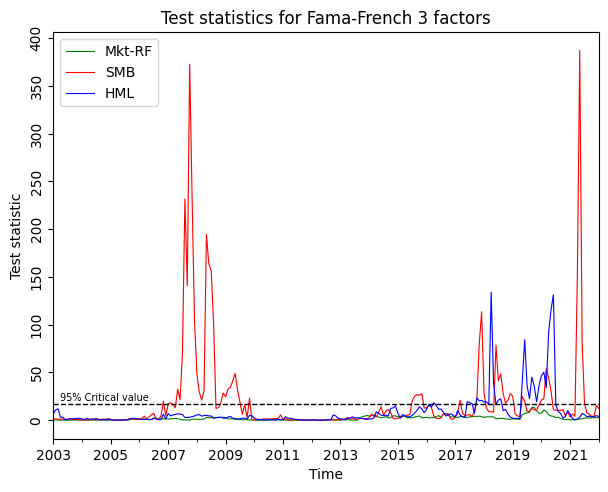

In [ ]:
# Chi1
colors=['g','r','b']


fig, ax = plt.subplots()
#fig=plt.figure()
for i in range(3):
  df[df.columns[i]].plot(c=colors[i],linewidth=0.8 )

plt.legend(df.columns[0:3])

df['Critical value'].plot( c='black', ls='dashed', linewidth=1 )

plt.text('2003-04-01', scipy.stats.chi2.ppf(0.95, 12-3)+3, "95% Critical value", fontsize = 7)

plt.title('Test statistics for Fama-French 3 factors')
plt.ylabel("Test statistic")
plt.xlabel("Time")

plt.yticks(rotation=90, va="center" )

#ax.set_xticklabels([2003,2022], ha='center')

zoom = 1.1
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.savefig('FF_3f_factor_test.eps', format='eps',bbox_inches='tight') # we muse fo this before plt.show() , see https://stackoverflow.com/questions/9012487/savefig-outputs-blank-image

plt.show()


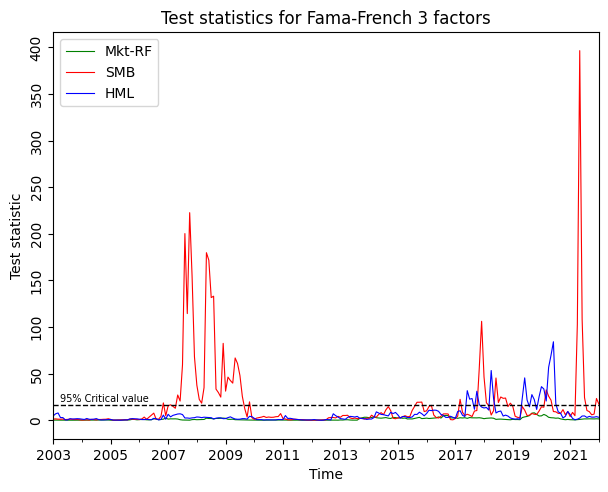

In [ ]:
# Chi2
colors=['g','r','b']


fig, ax = plt.subplots()
#fig=plt.figure()
for i in range(3):
  df[df.columns[i]].plot(c=colors[i],linewidth=0.8 )

plt.legend(df.columns[0:3])

df['Critical value'].plot( c='black', ls='dashed', linewidth=1 )

plt.text('2003-04-01', scipy.stats.chi2.ppf(0.95, 12-3)+3, "95% Critical value", fontsize = 7)

plt.title('Test statistics for Fama-French 3 factors')
plt.ylabel("Test statistic")
plt.xlabel("Time")

plt.yticks(rotation=90, va="center" )

#ax.set_xticklabels([2003,2022], ha='center')

zoom = 1.1
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.savefig('FF_3f_factor_test.eps', format='eps',bbox_inches='tight') # we muse fo this before plt.show() , see https://stackoverflow.com/questions/9012487/savefig-outputs-blank-image

plt.show()

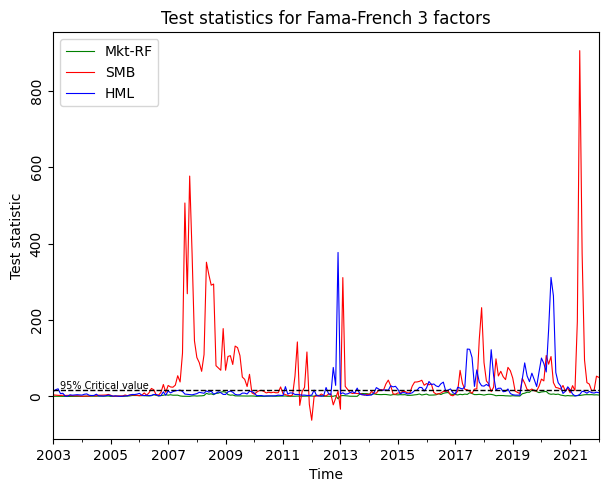

In [ ]:
# Chi3
colors=['g','r','b']


fig, ax = plt.subplots()
#fig=plt.figure()
for i in range(3):
  df[df.columns[i]].plot(c=colors[i],linewidth=0.8 )

plt.legend(df.columns[0:3])

df['Critical value'].plot( c='black', ls='dashed', linewidth=1 )

plt.text('2003-04-01', scipy.stats.chi2.ppf(0.95, 12-3)+3, "95% Critical value", fontsize = 7)

plt.title('Test statistics for Fama-French 3 factors')
plt.ylabel("Test statistic")
plt.xlabel("Time")

plt.yticks(rotation=90, va="center" )

#ax.set_xticklabels([2003,2022], ha='center')

zoom = 1.1
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.savefig('FF_3f_factor_test.eps', format='eps',bbox_inches='tight') # we muse fo this before plt.show() , see https://stackoverflow.com/questions/9012487/savefig-outputs-blank-image

plt.show()